In [112]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score

import matplotlib.pyplot as plt

In [113]:
data = pd.read_csv('data.csv')
X = data.iloc[:,:-1]
X['phone'] = X['phone'].apply(lambda x: int(str(x)[:3]))
y = data.iloc[:, -1]

In [114]:
X.head()

phone  paysum  paycount  maxpayment  CAT  citycount  federalOkrugsCount  \
0    900   100.0       1.0       100.0  3.0        1.0                 1.0   
1    900   997.0      30.0       100.0  2.0        2.0                 1.0   
2    900   150.0       1.0       150.0  3.0        1.0                 1.0   
3    900   100.0       1.0       100.0  3.0        1.0                 1.0   
4    900  2234.0       9.0      1000.0  1.0        1.0                 1.0   

   paymentRegions  
0             5.0  
1             5.0  
2             5.0  
3             5.0  
4             5.0

### Вывод 1
У абонентов звонивших клиенту гораздо шире диапазон кодов оператора связи

In [115]:
X[y == 1]['phone'].unique()

array([900, 901, 902, 903, 904, 905, 906, 908, 909, 910, 911, 912, 913,
       914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926,
       927, 928, 929, 930, 931, 932, 937, 933, 938, 950, 939, 951, 952,
       953, 960, 961, 962, 963, 964, 965, 967, 966, 968, 980, 981, 982,
       983, 985, 984, 987, 988, 989, 992, 995, 994], dtype=int64)

In [116]:
X[y == 0]['phone'].unique()

array([900, 901, 902, 903], dtype=int64)

### Вывод 2
Абоненты, звонившие клиенту, чаще платили в пользу сотовых операторов, чем случайные пользователи

In [117]:
X[y == 1]['CAT'].value_counts() / X[y == 1].shape[0]

3.0    0.866080799536319
1.0    0.095305230508952
2.0    0.038613969954728
Name: CAT, dtype: float64

In [118]:
X[y == 0]['CAT'].value_counts() / X[y == 0].shape[0]

3.0    0.769539423322276
2.0    0.153865782087267
1.0    0.076594794590457
Name: CAT, dtype: float64

### Избавимся от выбросов

In [119]:
xx = X['maxpayment']
#индексы выбросов
i1 = X[(xx > np.mean(xx) + 3* np.std(xx)) | (xx < np.mean(xx) - 3* np.std(xx))].index

xx = X['paysum']

i2 = X[(xx > np.mean(xx) + 3* np.std(xx)) | (xx < np.mean(xx) - 3* np.std(xx))].index

In [120]:
X.drop(index = np.unique(np.append(i1,i2)), inplace = True)
y.drop(index = np.unique(np.append(i1,i2)), inplace = True)

### Графики плотности
Случайные абоненты чаще платили в 1 федеральном округе, а так же в среднем платили в меньшем количестве городов

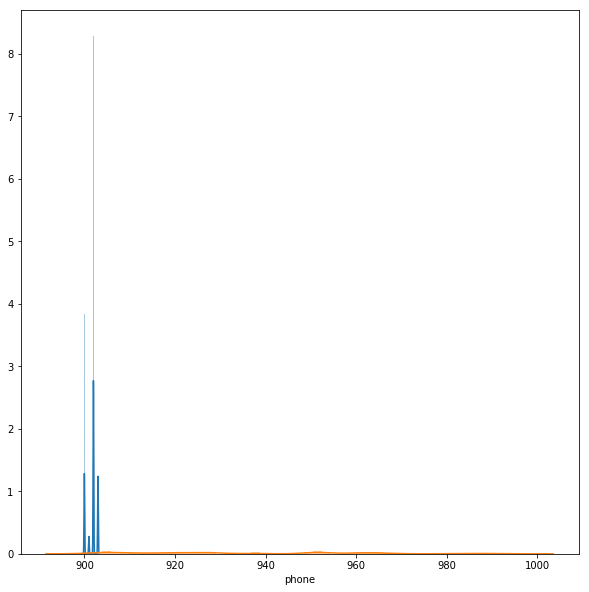

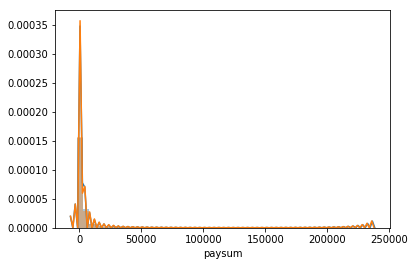

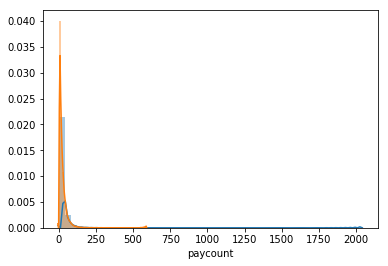

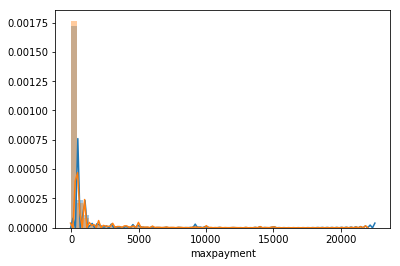

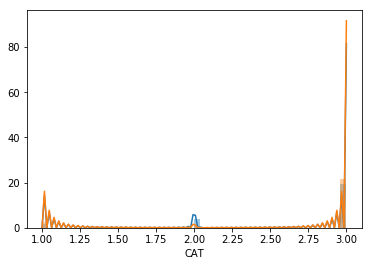

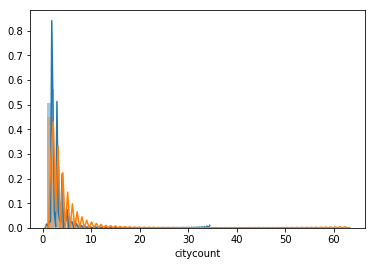

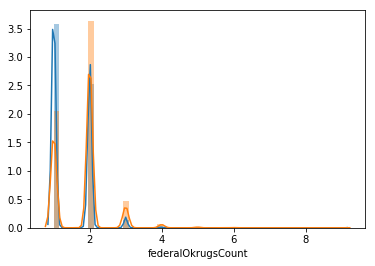

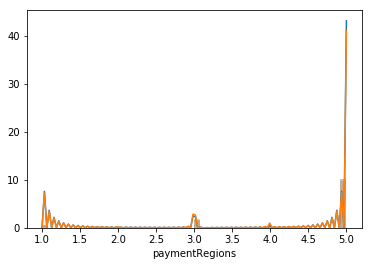

In [121]:
plt.figure(figsize = (10,10))

for col in X.columns:
    sns.distplot(X[y == 0][col])
    sns.distplot(X[y == 1][col])
    plt.show()

### Гипотеза
Первые **3 цифры номера** играют огромную роль, можно смотреть **только** на этот признак

Сравним точность классификации разбивая выборку с помощью кросс-валидации. 

Также посмотрим на график значений различных метрик в зависимости от глубины дерева.

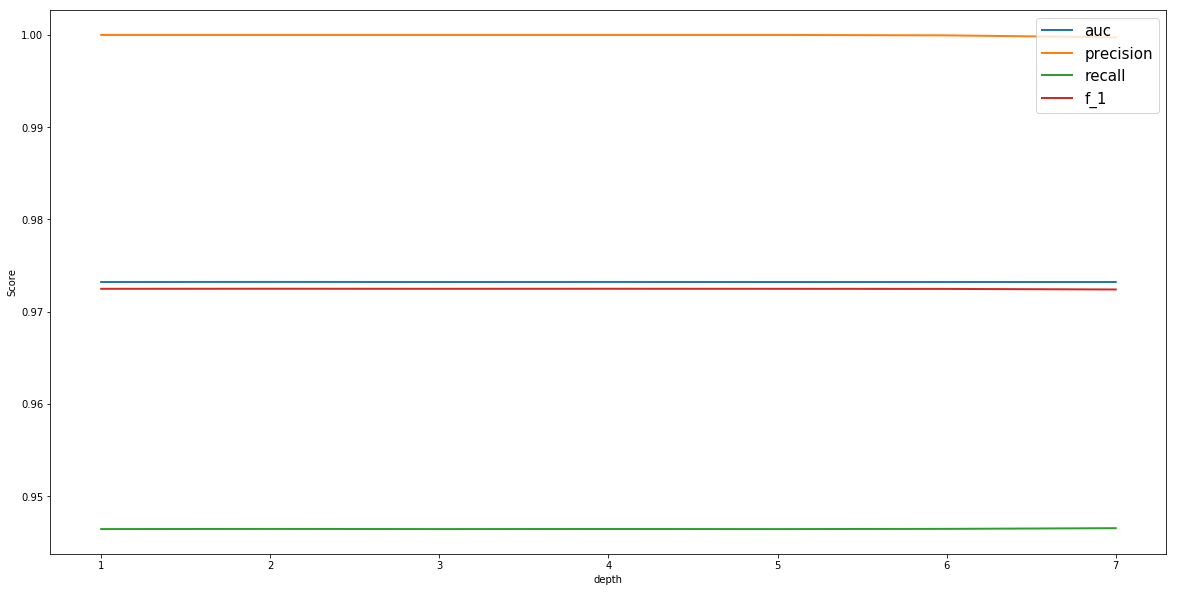

In [122]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import precision_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.model_selection import KFold 

fig = plt.figure(figsize=(20, 10)) 

_auc, _precision, _recall, _f_1 =[], [], [], [] 
depths = [1,2,3,4,5,6,7]

for depth in depths: 
    model = DecisionTreeClassifier(max_depth = depth) 
    kf = KFold(n_splits = 5, shuffle = True) 
    mean_auc, mean_precision, mean_recall, mean_f_1 = 0, 0, 0, 0 


    for tr_id, val_id in kf.split(X): 
        #тренировочная 
        X_tr, y_tr = X.iloc[tr_id, :], y.iloc[tr_id] 
        #валидационная 
        X_val, y_val = X.iloc[val_id, :], y.iloc[val_id] 

        model.fit(X_tr, y_tr) 
        y_pr = model.predict(X_val) 

        auc = roc_auc_score(y_val, y_pr) 
        precision = precision_score(y_val, y_pr) 
        recall = recall_score(y_val, y_pr) 
        f_1 = f1_score(y_val, y_pr) 

        mean_auc += auc/5 
        mean_precision += precision/5 
        mean_recall += recall/5 
        mean_f_1 += f_1/5
                              
    _auc.append(mean_auc) 
    _precision.append(mean_precision) 
    _recall.append(mean_recall) 
    _f_1.append(mean_f_1) 

plt.plot(depths, _auc, label='auc', linewidth=2) 
plt.plot(depths, _precision, label='precision',  linewidth=2) 
plt.plot(depths, _recall, label='recall',  linewidth=2) 
plt.plot(depths, _f_1, label='f_1',  linewidth=2) 

plt.xlabel('depth') 
plt.ylabel('Score') 
plt.legend(fontsize=15) 
plt.show()

### Можно посмотреть на попарную корреляцию признаков

На основе него можно делать предположения о линейной зависимости признаков

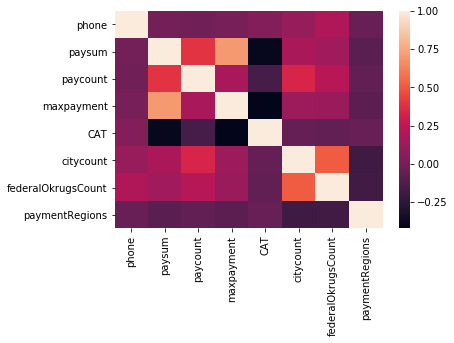

In [123]:
sns.heatmap(X.corr())

### Посмотрим, как будет проходить классификация, если убрать признак "phone"

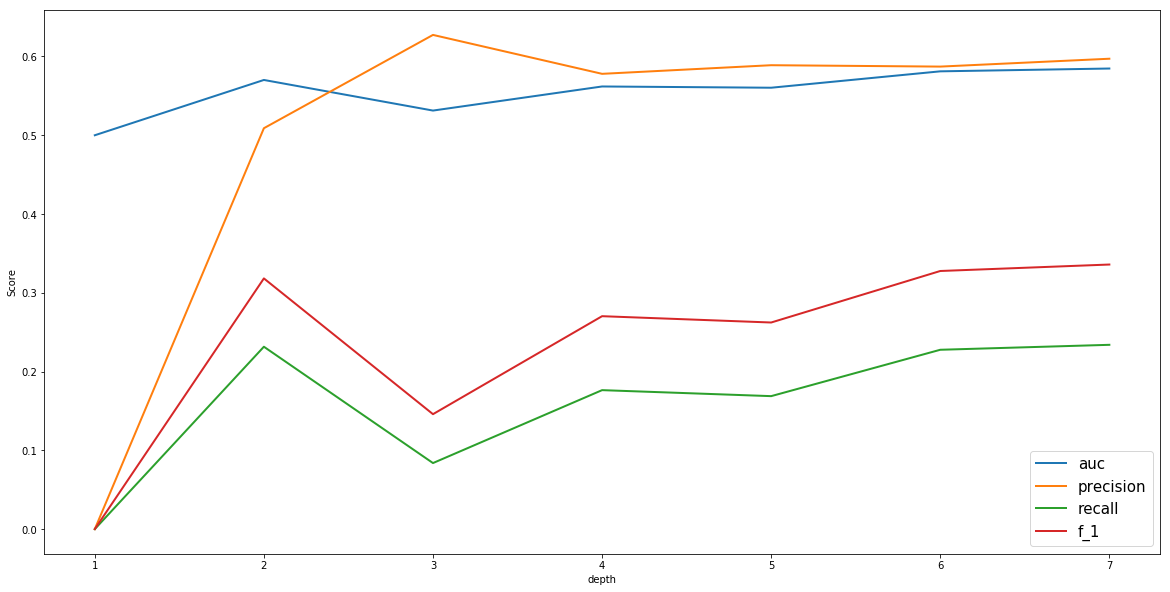

In [124]:
# Уберем колонку phone
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import precision_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.model_selection import KFold 

fig = plt.figure(figsize=(20, 10)) 

_auc, _precision, _recall, _f_1 =[], [], [], [] 
depths = [1,2,3,4,5,6,7]

for depth in depths: 
    model = DecisionTreeClassifier(max_depth = depth) 
    kf = KFold(n_splits = 5, shuffle = True) 
    mean_auc, mean_precision, mean_recall, mean_f_1 = 0, 0, 0, 0 


    for tr_id, val_id in kf.split(X): 
        #тренировочная 
        X_tr, y_tr = X.iloc[tr_id, 1:], y.iloc[tr_id] 
        #валидационная 
        X_val, y_val = X.iloc[val_id, 1:], y.iloc[val_id] 

        model.fit(X_tr, y_tr) 
        y_pr = model.predict(X_val) 

        auc = roc_auc_score(y_val, y_pr) 
        precision = precision_score(y_val, y_pr) 
        recall = recall_score(y_val, y_pr) 
        f_1 = f1_score(y_val, y_pr) 

        mean_auc += auc/5 
        mean_precision += precision/5 
        mean_recall += recall/5 
        mean_f_1 += f_1/5
                              
    _auc.append(mean_auc) 
    _precision.append(mean_precision) 
    _recall.append(mean_recall) 
    _f_1.append(mean_f_1) 

plt.plot(depths, _auc, label='auc', linewidth=2) 
plt.plot(depths, _precision, label='precision',  linewidth=2) 
plt.plot(depths, _recall, label='recall',  linewidth=2) 
plt.plot(depths, _f_1, label='f_1',  linewidth=2) 

plt.xlabel('depth') 
plt.ylabel('Score') 
plt.legend(fontsize=15) 
plt.show()

Точность резко падает, значит признак очень важен!!!

### Можно подобрать оптимальную глубину и получить более высокую точность

In [125]:
# Так AUC еще немного возрастет
from sklearn.tree import DecisionTreeClassifier

model  = DecisionTreeClassifier(max_depth = 2)
kf = KFold(n_splits = 5, shuffle = True)
mean_auc = 0

for tr_id, val_id in kf.split(X):
    
    X_tr, y_tr = X.iloc[tr_id, :], y.iloc[tr_id]
    X_val, y_val = X.iloc[val_id, :], y.iloc[val_id]
    
    model.fit(X_tr, y_tr)
    
    y_pr = model.predict(X_val)
    auc = roc_auc_score(y_val, y_pr)
    
    print(f'AUC: {auc}')
    mean_auc += auc/5
print(f'Mean AUC {mean_auc}')

AUC: 0.9721582333783462
AUC: 0.9728115668709728
AUC: 0.9744483159117305
AUC: 0.9735060690943044
AUC: 0.9731225296442687
Mean AUC 0.9732093429799245


## Выводы

Как мы видим при удалении первого столбца точность сильно падает(практически рандомная классификация). Остальные признаки не дают большого выиграша в точности. Поэтому абонентов, звонивших клиенту, от случайных пользователей отличает **первые три цифры номера телефона**.

Также выше мы отметили следующие отличия абонентов, звонивших к клиенту от случайных пользователей:

1) У абонентов, звонивших клиенту, **гораздо шире диапазон кодов оператора связи**.

2) Абоненты, звонившие клиенту **чаще всего платили в пользу сотовых операторов**, чем случайные пользователи.